# Example 1: Optimization of a State-to-State Transfer in a Two-Level-System

$
\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
$

This first example illustrates the basic use of the `Krotov.jl` by solving a
simple canonical optimization problem: the transfer of population in a two
level system.

In [1]:
using QuantumPropagators
using QuantumControlBase
using Krotov

## Two-level Hamiltonian

We consider the Hamiltonian $\op{H}_{0} = - \frac{\omega}{2} \op{\sigma}_{z}$, representing
a simple qubit with energy level splitting $\omega$ in the basis
$\{\ket{0},\ket{1}\}$. The control field $\epsilon(t)$ is assumed to couple via
the Hamiltonian $\op{H}_{1}(t) = \epsilon(t) \op{\sigma}_{x}$ to the qubit,
i.e., the control field effectively drives transitions between both qubit
states.

In [2]:
const σ̂_z = ComplexF64[1 0; 0 -1];
const σ̂_x = ComplexF64[0 1; 1  0];

In [3]:
"""Two-level-system Hamiltonian."""
function hamiltonian(Ω=1.0, E0=0.2)
    Ĥ₀ = -0.5 * Ω * σ̂_z
    Ĥ₁ = σ̂_x
    ϵ(t) = E0 * flattop(t, T=5, t_rise=0.3, func=:blackman)
    return (Ĥ₀, (Ĥ₁, ϵ))
end
;

In [4]:
H = hamiltonian();

The control field here switches on from zero at $t=0$ to it's maximum amplitude
0.2 within the time period 0.3 (the switch-on shape is half a [Blackman pulse](https://en.wikipedia.org/wiki/Window_function#Blackman_window)).
It switches off again in the time period 0.3 before the
final time $T=5$). We use a time grid with 500 time steps between 0 and $T$:

In [5]:
tlist = collect(range(0, 5, length=500));

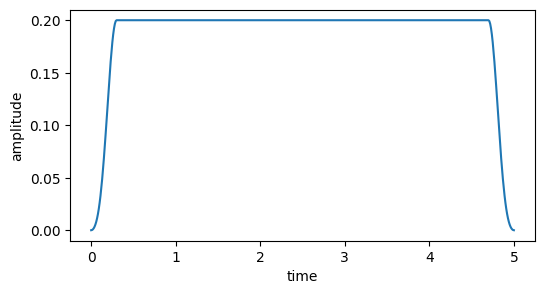

In [6]:
using PyPlot

function plot_pulse(pulse::Vector, tlist)
    fig, ax = matplotlib.pyplot.subplots(figsize=(6, 3))
    ax.plot(tlist, pulse)
    ax.set_xlabel("time")
    ax.set_ylabel("amplitude")
    return fig
end

plot_pulse(ϵ::T, tlist) where T<:Function =
    plot_pulse([ϵ(t) for t in tlist], tlist)

plot_pulse(H[2][2], tlist)

## Optimization target

The `krotov` package requires the goal of the optimization to be described by a
list of `Objective` instances. In this example, there is only a single
objective: the state-to-state transfer from initial state $\ket{\Psi_{\init}} =
\ket{0}$ to the target state $\ket{\Psi_{\tgt}} = \ket{1}$, under the dynamics
of the Hamiltonian $\op{H}(t)$:

In [7]:
function ket(label)
    result = Dict(
        "0" => Vector{ComplexF64}([1, 0]),
        "1" => Vector{ComplexF64}([0, 1]),
    )
    return result[string(label)]
end
;

In [8]:
objectives = [Objective(initial_state=ket(0), generator=H, target=ket(1))]

1-element Vector{QuantumControlBase.Objective}:
 QuantumControlBase.Objective(ComplexF64[1.0 + 0.0im, 0.0 + 0.0im], (ComplexF64[-0.5 - 0.0im -0.0 - 0.0im; -0.0 - 0.0im 0.5 - 0.0im], (ComplexF64[0.0 + 0.0im 1.0 + 0.0im; 1.0 + 0.0im 0.0 + 0.0im], Main.##258.var"#ϵ#1"{Float64}(0.2))), ComplexF64[0.0 + 0.0im, 1.0 + 0.0im])

In [9]:
problem = ControlProblem(
    objectives=objectives,
    pulse_options=Dict(
        H[2][2]  => Dict(
            :lambda_a => 5,
            :update_shape => t -> flattop(t, T=5, t_rise=0.3, func=:blackman),
        )
    ),
    tlist=tlist,
    iter_stop=10,
);

## Simulate dynamics under the guess field

Before running the optimization procedure, we first simulate the dynamics under the
guess field $\epsilon_{0}(t)$. The following solves equation of motion for the
defined objective, which contains the initial state $\ket{\Psi_{\init}}$ and
the Hamiltonian $\op{H}(t)$ defining its evolution.

In [10]:
guess_dynamics = propagate(
        objectives[1], problem.tlist;
        storage=true, observables=(Ψ->abs.(Ψ).^2, )
)

2×500 Matrix{Float64}:
 1.0  1.0          1.0          1.0          …  0.951457   0.951459  0.951459
 0.0  7.73456e-40  2.03206e-11  2.96638e-10     0.0485427  0.048541  0.048541

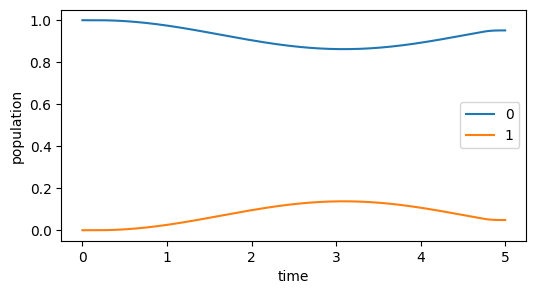

In [11]:
function plot_population(pop0::Vector, pop1::Vector, tlist)
    fig, ax = matplotlib.pyplot.subplots(figsize=(6, 3))
    ax.plot(tlist, pop0, label="0")
    ax.plot(tlist, pop1, label="1")
    ax.legend()
    ax.set_xlabel("time")
    ax.set_ylabel("population")
    return fig
end

plot_population(guess_dynamics[1,:], guess_dynamics[2,:], tlist)

## Optimize

In the following we optimize the guess field $\epsilon_{0}(t)$ such
that the intended state-to-state transfer $\ket{\Psi_{\init}} \rightarrow
\ket{\Psi_{\tgt}}$ is solved, via the `krotov` package's central
`optimize_pulses` routine.  It requires, besides the previously defined
`objectives`, information about the optimization functional $J_T$ (implicitly,
via `chi_constructor`, which calculates the states $\ket{\chi} =
\frac{J_T}{\bra{\Psi}}$).

In [12]:
opt_result = optimize_pulses(problem)

[ Info: Initial Forward Propagation
[ Info: Krotov iteration 1
[ Info: Krotov iteration 2
[ Info: Krotov iteration 3
[ Info: Krotov iteration 4
[ Info: Krotov iteration 5
[ Info: Krotov iteration 6
[ Info: Krotov iteration 7
[ Info: Krotov iteration 8
[ Info: Krotov iteration 9
[ Info: Krotov iteration 10


Krotov Optimization Result
--------------------------
- Started at 2021-08-24T19:49:10.475
- Number of objectives: 1
- Number of iterations: 10
- Reason for termination: finished
- Ended at 2021-08-24T19:49:13.281 (2806 milliseconds)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*